Phase 3 is Predictive Modeling
 
1.	Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
2.	Create data partition into train and test data sets (80/20)
3.	Run Binary Logistic Regression with Nifty Direction as dependent variable and previous day global market returns (and VIX) as independent variables.  
You may add more features such as previous day High/Low ratio for Nifty 50 and/or DJI
4.	Check multicollinearity and resolve if present
5.	Check which variables are significant (revise the model if needed)
6.	Obtain ROC curve and AUC for train data
7.	Obtain threshold to balance sensitivity and specificity
  	Go to step 8 only if you are satisfied with model on train data 
8. Obtain ROC curve and AUC for test data (compare with step 6)
9. Use above threshold to obtain sensitivity and specificity for test data 
         (compare with step 7)
10.	Finalize the model

In [57]:
import pandas as pd
import numpy as np

df = pd.read_csv('markets_with_returns.csv')

# List of market return columns to be used in methods below
independent_vars = [
    'DowJones_Return', 'Nasdaq_Return',
    'HangSeng_Return', 'Nikkei_Return',
    'DAX_Return', 'VIX_Return' ]


In [58]:
# Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
df['Nifty_Dir_Open'] = (df['Nifty_Return'] > 0).astype(int)

In [59]:
# Create data partition into train and test data sets (80/20)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)


In [60]:
import statsmodels.api as sm

# Add a constant to the independent variables (for the intercept term)
X_train = sm.add_constant(train_df[independent_vars])
X_test = sm.add_constant(test_df[independent_vars])
# Define the dependent variable
y_train = train_df['Nifty_Dir_Open']
y_test = test_df['Nifty_Dir_Open']

# Build the logistic regression model
model = sm.Logit(y_train.astype(int), X_train.astype(int)).fit()

# Summarize the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.674840
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Nifty_Dir_Open   No. Observations:                 1317
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            6
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                 0.02425
Time:                        22:38:32   Log-Likelihood:                -888.76
converged:                       True   LL-Null:                       -910.85
Covariance Type:            nonrobust   LLR p-value:                 6.834e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1227      0.057     -2.153      0.031      -0.234      -0.011
DowJones_Retur

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Check multicollinearity and remove variables with high VIF if necessary

# Check VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

# remove from indenpendent_vars any variable with VIF > 5
filtered_vars = []

# Loop through each variable in the original list
for var in independent_vars:
    # Find the VIF value for this variable
    vif_value = vif_data.loc[vif_data['feature'] == var, 'VIF'].values[0]

    # Check if VIF is acceptable (≤ 5)
    if vif_value <= 5:
        filtered_vars.append(var)

# Update the independent_vars list
independent_vars = filtered_vars

print(f"\nFinal variables after VIF filtering: {independent_vars}")



           feature       VIF
0            const  1.017287
1  DowJones_Return  2.675224
2    Nasdaq_Return  2.485189
3  HangSeng_Return  1.054181
4    Nikkei_Return  1.063267
5       DAX_Return  1.227375
6       VIX_Return  2.055600

Final variables after VIF filtering: ['DowJones_Return', 'Nasdaq_Return', 'HangSeng_Return', 'Nikkei_Return', 'DAX_Return', 'VIX_Return']


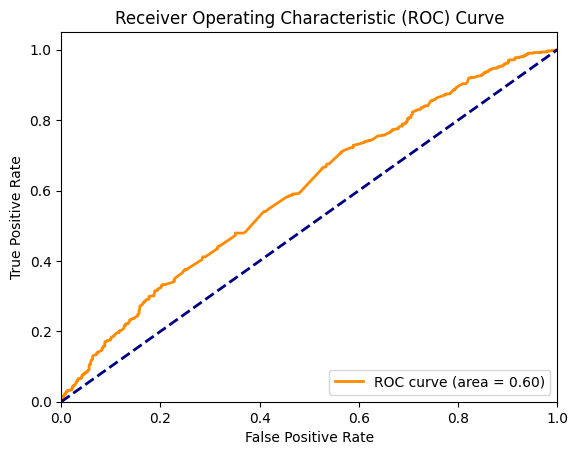

AUC: 0.60


In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on the train set and calculate ROC AUC
train_df['predprob'] = model.predict(X_train.astype(int))
fpr, tpr, thresholds = roc_curve(y_train, train_df['predprob'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Print AUC
print(f"AUC: {roc_auc:.2f}")



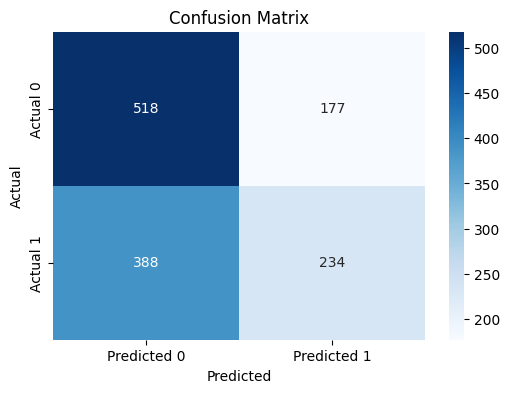

classification report:
               precision    recall  f1-score   support

           0       0.57      0.75      0.65       695
           1       0.57      0.38      0.45       622

    accuracy                           0.57      1317
   macro avg       0.57      0.56      0.55      1317
weighted avg       0.57      0.57      0.56      1317



In [71]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix and Classification Report
y_pred = model.predict(X_train.astype(int)) >= 0.5
cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("classification report:\n", cr)



In [76]:
# Overall accuracy is very low, looking for a better threshold based on ROC curve
# Method 1: Youden's Index (maximizes TPR - FPR)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold_youden = thresholds[optimal_idx]
print(f"Optimal threshold by Youden's Index: {optimal_threshold_youden:.4f}")

# Given that the new threshold is similar to 0.5 (.46), we will keep using 0.5 for classification since
# specificity and sensitivity are balanced around this point.


Optimal threshold by Youden's Index: 0.4600


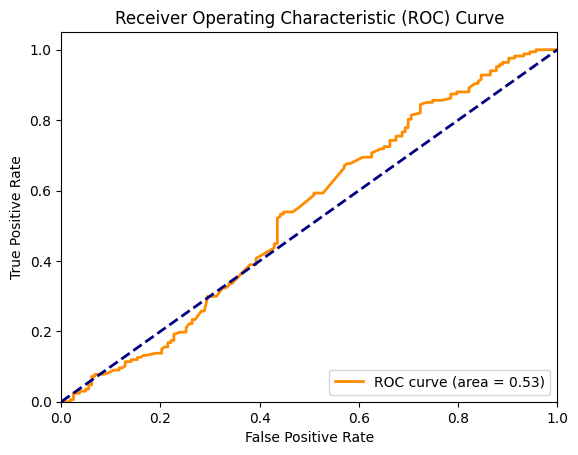

AUC: 0.53


In [ ]:
# Predict probabilities on the test set and calculate ROC AUC
test_df['predprob'] = model.predict(X_test.astype(int))
fpr_test, tpr_test, thresholds = roc_curve(y_test, test_df['predprob'])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Print AUC
print(f"AUC: {roc_auc_test:.2f}")

# The performance on the test set is consistent with the train set, very low AUC around 0.53 and 0.60 in test and train respectively.

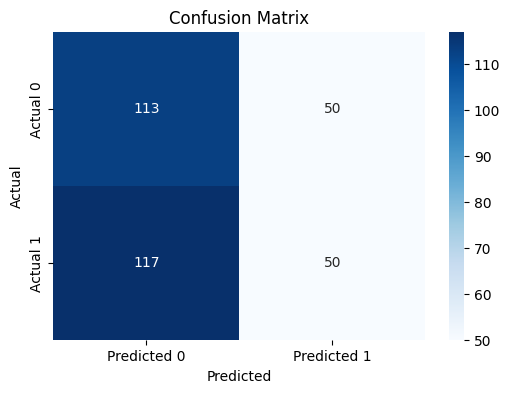

classification report:
               precision    recall  f1-score   support

           0       0.49      0.69      0.58       163
           1       0.50      0.30      0.37       167

    accuracy                           0.49       330
   macro avg       0.50      0.50      0.47       330
weighted avg       0.50      0.49      0.47       330



In [66]:
# Confusion Matrix and Classification Report
y_pred_test = model.predict(X_test.astype(int)) >= 0.5
cm = confusion_matrix(y_test, y_pred_test)
cr = classification_report(y_test, y_pred_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("classification report:\n", cr)

# Overall accuracy is very low, at 48% is even lower than the train set at 58%.